In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sb
import time
#from ipywidgets import interact, fixed
from libs.CovidTimeseriesModel import CovidTimeseriesModel 
from libs.CovidTimeseriesModelSIR import CovidTimeseriesModelSIR
from libs.CovidDatasets import CDSDataset, JHUDataset
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [4]:
Dataset = JHUDataset()

def model_state(country, state, interventions=None):
   
    # we should cut this, only used by the get_timeseries function, but probably not needed
    MODEL_INTERVAL = 4


    # Pack all of the assumptions and parameters into a dict that can be passed into the model    
    DATA_PARAMETERS = {
        'timeseries': Dataset.get_timeseries_by_country_state(country, state, MODEL_INTERVAL),
        'beds': Dataset.get_beds_by_country_state(country, state),  
        'population': Dataset.get_population_by_country_state(country, state),
    }
    
    MODEL_PARAMETERS = {        
        'model': 'seir',

        'use_harvard_params': False, #If True use the harvard parameters directly, if not calculate off the above
        'fix_r0': False, #If True use the parameters that make R0 2.4, if not calculate off the above
        
        'days_to_model': 270,

        'hospitalization_rate': 0.0727,
        #'hospitalization_rate': 0.2,
        'hospitalized_cases_requiring_icu_care': 0.1397,

        ## Variables for calculating model parameters Hill -> our names/calcs    
        # IncubPeriod: Average incubation period, days - presymptomatic_period
        # DurMildInf: Average duration of mild infections, days - duration_mild_infections
        # FracMild: Average fraction of (symptomatic) infections that are mild - (1 - hospitalization_rate)
        # FracSevere: Average fraction of (symptomatic) infections that are severe - hospitalization_rate * hospitalized_cases_requiring_icu_care
        # FracCritical: Average fraction of (symptomatic) infections that are critical - hospitalization_rate * hospitalized_cases_requiring_icu_care
        # CFR: Case fatality rate (fraction of infections that eventually result in death) - case_fatality_rate
        # DurHosp: Average duration of hospitalization (time to recovery) for individuals with severe infection, days - hospital_time_recovery
        # TimeICUDeath: Average duration of ICU admission (until death or recovery), days - icu_time_death 
        
        # LOGIC ON INITIAL CONDITIONS:
        # hospitalized = case load from timeseries on last day of data / 4
        # mild = hospitalized / hospitalization_rate
        # icu = hospitalized * hospitalized_cases_requiring_icu_care
        # expoosed = exposed_infected_ratio * mild
        
        'total_infected_period': 12, # In days
        'duration_mild_infections': 6, # In days
        
        'hospital_time_recovery': 11, #Duration of hospitalization, In days
        'icu_time_death': 7, #Time from ICU admission to death, In days
        'case_fatality_rate': .0109341104294479,

        'beta': 0.5,
        'beta_hospitalized': 0.1,
        'beta_icu': 0.1,

        'presymptomatic_period': 5,
        'exposed_from_infected': True,

        'hospital_capacity_change_daily_rate': 1.05,
        'max_hospital_capacity_factor': 2.07,
        'initial_hospital_bed_utilization': .6,     

        'interventions': interventions,
    }
    
    MODEL_PARAMETERS['case_fatality_rate_hospitals_overwhelmed'] = MODEL_PARAMETERS['hospitalization_rate'] * MODEL_PARAMETERS['hospitalized_cases_requiring_icu_care']
    
    MODEL_PARAMETERS['exposed_infected_ratio'] = 1
    
    MODEL_PARAMETERS.update(DATA_PARAMETERS)
    
    return CovidTimeseriesModelSIR().forecast_region(model_parameters=MODEL_PARAMETERS)
             
INTERVENTIONS = [
    None, 
    {
        datetime.date(2020, 3, 23): 1.3,
        datetime.date(2020, 4, 20): 1.1,
        datetime.date(2020, 5, 22): 0.8,
        datetime.date(2020, 6, 23): 3.087079333
    },
    {
        datetime.date(2020, 3, 23): 1.7,
        datetime.date(2020, 6, 23): 3.087079333
    },
    {
        datetime.date(2020, 3, 23): 1.3,
        datetime.date(2020, 3, 31): 0.3,
        datetime.date(2020, 4, 28): 0.2,
        datetime.date(2020, 5,  6): 0.1,
        datetime.date(2020, 5, 10): 0.035,
        datetime.date(2020, 5, 18): 3.087079333
    },   
    {
        datetime.date(2020, 4, 3): 1.3,
        datetime.date(2020, 5, 18): 3.087079333

    },
    {
        datetime.date(2020, 3, 3): 5,
    },
]

In [5]:
[df, soln] = model_state('USA', 'TX', INTERVENTIONS[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24707 entries, 0 to 24706
Data columns (total 8 columns):
index        24707 non-null int64
date         24707 non-null datetime64[ns]
country      24707 non-null object
state        20619 non-null object
county       16784 non-null object
cases        24688 non-null float64
deaths       24266 non-null float64
recovered    24319 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 1.5+ MB


[1.37057997e+08 1.64494340e+08 2.19275599e+07 1.01475707e+06
 8.07990221e+09 4.35575451e+07]
(365, 6)


(1, 28995881.0)

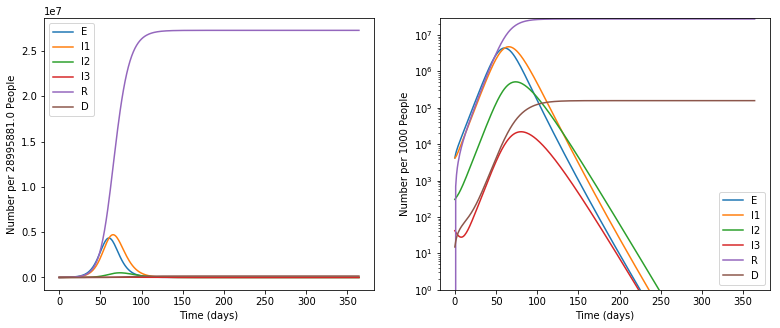

In [6]:
# TODO: This is fixed N for TX, get N from datasource and use it

# Note, this will show the ODE solution for the last-run intervention step

tmax = 365
N =  28995881.00
tvec=np.arange(0,tmax,1)
    
#print(np.array(N-np.sum(soln,axis=1,keepdims=True)))
#s = [N-np.sum(soln,axis=1,keepdims=True)]
#s = np.max(s,0)
soln_plt = np.hstack([soln])
#soln_plt = np.hstack(soln)

print(sum(soln_plt))
print(soln_plt.shape)

plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(tvec,soln_plt)
plt.xlabel("Time (days)")
plt.ylabel(f"Number per {str(N)} People")
#plt.legend(("S","E","I1","I2","I3","R","D"))
plt.legend(("E","I1","I2","I3","R","D"))

#plt.ylim([0,N])

#Same plot but on log scale
plt.subplot(1,2,2)
plt.plot(tvec,soln_plt)
plt.semilogy()
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000 People")
#plt.legend(("S","E","I1","I2","I3","R","D"))
plt.legend(("E","I1","I2","I3","R","D"))

plt.ylim([1,N])
#plt.tight_layout()